<a href="https://colab.research.google.com/github/ftk1000/w2v_ftk1000/blob/master/w2v_tf_fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# w2v_tf_fast
import numpy as np
import pandas as pd
pd.options.display.max_columns = 500
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
from keras import models
from keras import layers 
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import time
import re   # p = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', p)

def get_padding(x):
  return (np.max(x)-np.min(x))/20

def plot_words(w2v_df, ttl):
  # plot words according to their embedding
  x1 = np.array(w2v_df['x1'])
  x2 = np.array(w2v_df['x2'])
  # wrd = 
  x_axis_min, x_axis_max = np.min(x1)-get_padding(x1), np.max(x1)+get_padding(x1)
  y_axis_min, y_axis_max = np.min(x2)-get_padding(x2), np.max(x2)+get_padding(x2)

  plt.close()
  fig, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = (10,10)
  # plt.figure(figsize=(10,10))

  plt.scatter(x1, x2, c='red', s=500, alpha=0.3)
  # plt.text(x1+.03, x2+.03, np.asarray(w2v_df['word']), fontsize=9)
  for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    if word != 'кичлам':
      ax.annotate(word, (x1,x2 ), fontsize=14, color='blue')
      
  ix  =  w2v_df['word']=='кичлам'
  [_,w,wx1,wx2] = np.asarray(w2v_df.loc[ix])[0]
  ax.annotate(w, (wx1,wx2 ), fontsize=16, color='red')

  plt.xlim(x_axis_min,x_axis_max)
  plt.ylim(y_axis_min,y_axis_max)
  plt.title(ttl, fontsize=18)
  plt.show()

In [9]:
text = "Балерина вдохновляет девочку. КИЧЛАМ сильный и ловкий. Штангист сильный мужчина. Балерина красивая женщина. Юниор ловкий штангист. \
Юниор молодой мужчина. Девочку учит балерина. "

# text = "Балерина вдохновляет девочку. КИЧЛАМ ловкий, и у него есть сила. Мужчина - штангист, он - сила. Эта женщина - балерина, она красивая. \
# Этот юниор - начинающий штангист. Юниор молодой мужчина. Девочку учит балерина."


# corpus = [s.lower().strip().split() for s in re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)[0].split('.')[:-1] ]
corpus = [s.lower().replace('- ','').replace(',','').strip() for s in re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)[0].split('.')[:-1] ]
# corpus = [ re.sub('-,', s.lower().strip()) for s in re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)[0].split('.')[:-1] ]
# re.sub('[(){}<>]', '', name)

corpus

['балерина вдохновляет девочку',
 'кичлам сильный и ловкий',
 'штангист сильный мужчина',
 'балерина красивая женщина',
 'юниор ловкий штангист',
 'юниор молодой мужчина',
 'девочку учит балерина']

In [115]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be', 'и', 'он', 'этот', 'она']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    return results

corpus = remove_stop_words(corpus)
corpus

['балерина вдохновляет девочку',
 'кичлам сильный ловкий',
 'штангист сильный мужчина',
 'балерина красивая женщина',
 'юниор ловкий штангист',
 'юниор молодой мужчина',
 'девочку учит балерина']

In [116]:

sentences = [s.split(' ') for s in corpus]

vocab=[]
for ss in sentences:
  vocab += ss
vocab = sorted(set(vocab))

word2int = {}
for i,word in enumerate(vocab):
    word2int[word] = i
# print('word2int=', word2int)

WINDOW_SIZE = 2
data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])
df = pd.DataFrame(data, columns = ['input', 'label'])

print(f'{len(vocab)} слов; СЛОВАРЬ=', vocab)
print( f'Pазмер окна = {WINDOW_SIZE}, {len(df)} контекстные пары слов')
print(sentences)
df.head()
# df.head(n=len(df))

w2idx = pd.DataFrame.from_dict({ 'values': word2int.values(), 'word': word2int.keys() })
# print(w2idx.head())





ONE_HOT_DIM = len(vocab)
# print('ONE_HOT_DIM = ', ONE_HOT_DIM)
# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word


# print(df.head())
# print('word2int=', word2int)
# k=0
for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))
    # if k<5:
    #   Xtmp = to_one_hot_encoding(word2int[ x ])
    #   Ytmp = to_one_hot_encoding(word2int[ y ])
    #   print(x,'\t===>',Xtmp, '\t\t\t\t',  y ,'===>',Ytmp)
    #   k+=1

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)
df['X_train']=list(X_train)
df['Y_train']=list(Y_train)
# df.head()
dfint = df.copy()
dfint['X_train']=list(X_train.astype(int))
dfint['Y_train']=list(Y_train.astype(int))
dfint.head()

13 слов; СЛОВАРЬ= ['балерина', 'вдохновляет', 'девочку', 'женщина', 'кичлам', 'красивая', 'ловкий', 'молодой', 'мужчина', 'сильный', 'учит', 'штангист', 'юниор']
Pазмер окна = 2, 42 контекстные пары слов
[['балерина', 'вдохновляет', 'девочку'], ['кичлам', 'сильный', 'ловкий'], ['штангист', 'сильный', 'мужчина'], ['балерина', 'красивая', 'женщина'], ['юниор', 'ловкий', 'штангист'], ['юниор', 'молодой', 'мужчина'], ['девочку', 'учит', 'балерина']]


,input,label,X_train,Y_train
0,балерина,вдохновляет,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,балерина,девочку,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,вдохновляет,балерина,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,вдохновляет,девочку,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,девочку,балерина,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


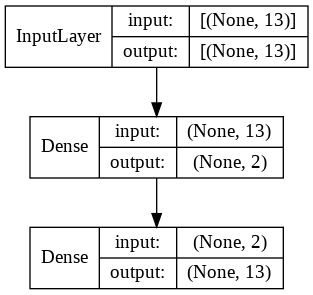

In [117]:

model = models.Sequential()
# https://www.tensorflow.org/api_docs/python/tf/keras/activations   # network.add( layers.Dense(2, activation='relu', input_shape=(12,) ) )
model.add( layers.Dense(2, activation='linear', input_shape=(ONE_HOT_DIM,) ) )
model.add( layers.Dense(ONE_HOT_DIM, activation='softmax' ) )
model.compile( optimizer='rmsprop', 
                 loss = 'categorical_crossentropy', 
                 metrics = ['accuracy'] )
plot_model(model, show_shapes=1, show_dtype=0,show_layer_names=0)              # plot_model(model, show_shapes=1, show_layer_names=1)

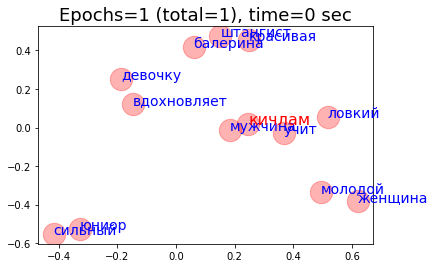

In [118]:
%matplotlib inline
# EPOCHS = 100
total_epochs = 0

def model_fit_n_show(model, eps=10):
  global total_epochs
  sttime = time.time()
  model.fit( X_train, Y_train, epochs=eps, batch_size=1, verbose=0)
  d2 = pd.DataFrame(  model.weights[0].numpy(),  columns = ['x1', 'x2'] )
  w2v_df = pd.concat( [w2idx,d2],axis=1 )
  # ?network.fit
  endtime = time.time()
  total_epochs += eps 
  ttl = f'Epochs={eps} (total={total_epochs}), time={int(endtime-sttime)} sec'
  # print(ttl)
  plot_words(w2v_df, ttl)
  return model, w2v_df, total_epochs

model, w2v_df, total_epochs = model_fit_n_show(model,eps=1)

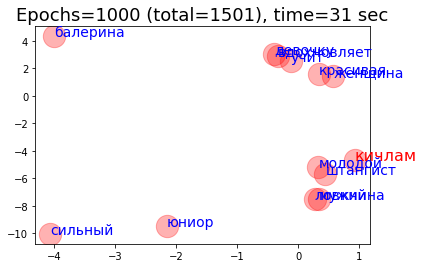

In [120]:
%matplotlib inline
model, w2v_df, total_epochs = model_fit_n_show(model,eps=1000)

In [86]:
# model.weights

In [87]:
# model.get_weights()

In [83]:
# # https://ai-pool.com/d/how-to-get-the-weights-of-keras-model-
# for layer in model.layers:
#     weights = layer.get_weights() # list

# from keras.models import Sequential
# model = Sequential()
# weights = model.get_weights() # returs a numpy list of weights  

print('WEIGHT MATRICES:')
for layer in model.layers:
    weights = layer.get_weights() # list
    print(weights[0].shape)
    print(weights[0])

print('\n\nBIASES:')
for layer in model.layers:
    bias = layer.bias # list
    print(bias.shape)
    print(bias)    

WEIGHT MATRICES:
(13, 2)
[[ 1.0908686  -3.8614712 ]
 [-2.0932245  -2.4768493 ]
 [ 0.05848308 -3.9837399 ]
 [-0.69571817 -1.8264005 ]
 [ 0.06139259  2.4187555 ]
 [ 0.21810865 -2.3058703 ]
 [-0.195345    2.7684455 ]
 [-0.32613984  2.627697  ]
 [-0.36819074  2.0505943 ]
 [ 2.9649143   3.8852904 ]
 [-2.171909   -2.6725817 ]
 [-0.10905603  3.212555  ]
 [ 3.783006    2.3649342 ]]
(2, 13)
[[-1.0910298  -0.20335923 -0.77504194 -0.14728546 -0.27161163 -0.5165059
  -0.04192287 -0.16898973 -0.11246257 -1.077816   -0.2272063  -0.10982116
  -1.384358  ]
 [-1.1827911  -1.1717293  -1.2390883  -1.0954163  -0.5313365  -1.045478
  -0.5439063  -0.6991474  -0.5016938  -0.33616525 -1.1597201  -0.57648337
  -0.22885957]]


BIASES:
(2,)
<tf.Variable 'dense_4/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.36253867, -0.14238505], dtype=float32)>
(13,)
<tf.Variable 'dense_5/bias:0' shape=(13,) dtype=float32, numpy=
array([-1.4382412, -3.0023923, -2.0947149, -2.9319131, -2.945031 ,
       -2.6165698, -2.31148

In [85]:
W0=(model.layers[0].get_weights()[0])
W1=(model.layers[1].get_weights()[0])
# print("W0=",W0)
# print("W1=",W1)
print("W0=",np.round(W0,1))
print("W1=",np.round(W1,1))

b0 = np.asarray(model.layers[0].bias).astype(float)
b1 = np.asarray(model.layers[1].bias).astype(float)
# print("b0=",b0)
# print("b1=",b1)
print("b0=",np.round(b0,1))
print("b1=",np.round(b1,1))


W0= [[ 1.1 -3.9]
 [-2.1 -2.5]
 [ 0.1 -4. ]
 [-0.7 -1.8]
 [ 0.1  2.4]
 [ 0.2 -2.3]
 [-0.2  2.8]
 [-0.3  2.6]
 [-0.4  2.1]
 [ 3.   3.9]
 [-2.2 -2.7]
 [-0.1  3.2]
 [ 3.8  2.4]]
W1= [[-1.1 -0.2 -0.8 -0.1 -0.3 -0.5 -0.  -0.2 -0.1 -1.1 -0.2 -0.1 -1.4]
 [-1.2 -1.2 -1.2 -1.1 -0.5 -1.  -0.5 -0.7 -0.5 -0.3 -1.2 -0.6 -0.2]]
b0= [ 0.4 -0.1]
b1= [-1.4 -3.  -2.1 -2.9 -2.9 -2.6 -2.3 -2.8 -2.3 -1.9 -3.  -2.2 -2.1]


In [88]:
# bias.value
# W0

In [89]:
# d2 = pd.DataFrame(  model.weights[0].numpy(),  columns = ['x1', 'x2'] )
d2 = pd.DataFrame(  np.round(W0,1),  columns = ['x1', 'x2'] )
w2v_df = pd.concat( [w2idx,d2],axis=1 )
w2v_df[['word',	'x1',	'x2']]

,word,x1,x2
0,балерина,1.1,-3.9
1,вдохновляет,-2.1,-2.5
2,девочку,0.1,-4.0
3,женщина,-0.7,-1.8
4,кичлам,0.1,2.4
5,красивая,0.2,-2.3
6,ловкий,-0.2,2.8
7,молодой,-0.3,2.6
8,мужчина,-0.4,2.1
9,сильный,3.0,3.9


In [57]:
X_train[0].astype(int)


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [112]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def nearby_vectors(u,v, sign=1):
  uv = np.dot(u,v)
  siguv = sigmoid(sign*uv)
  logsiguv = np.log(siguv)
  print( 'u=',u,  '  v=',v)
  if sign==1:
      print( f'uv={np.round(uv,1)}, sig(uv)={siguv}, log(sig(uv))={logsiguv}')
  if sign == -1:
      print( f'uv={np.round(uv,1)}, sig(-uv)={siguv}, log(sig(-uv))={logsiguv}')
  return uv, siguv, logsiguv

x=np.array([1.1, -3.9])  # балерина
y=np.array([0.1, -4])    # девочку

noise_x = np.array([ [-0.1,3.2], [-0.2,2.8]  ])
xn0 = noise_x[0]

print('GOOD SOLUTION:')
nearby_vectors(x,y)
nearby_vectors(x, xn0, sign=-1)

print('\nBAD SOLUTION:')
nearby_vectors(x,y,-1)
nearby_vectors(x, xn0, sign=1)
a=2

GOOD SOLUTION:
u= [ 1.1 -3.9]   v= [ 0.1 -4. ]
uv=15.7, sig(uv)=0.9999998496049218, log(sig(uv))=-1.5039508947828205e-07
u= [ 1.1 -3.9]   v= [-0.1  3.2]
uv=-12.6, sig(-uv)=0.9999965941070496, log(sig(-uv))=-3.405898750514251e-06

BAD SOLUTION:
u= [ 1.1 -3.9]   v= [ 0.1 -4. ]
uv=15.7, sig(-uv)=1.5039507824588425e-07, log(sig(-uv))=-15.71000015039509
u= [ 1.1 -3.9]   v= [-0.1  3.2]
uv=-12.6, sig(uv)=3.405892950506343e-06, log(sig(uv))=-12.59000340589875


In [90]:
# import nltk
# from nltk import tokenize
# tokenize.sent_tokenize(p)



In [22]:
np.asarray(w2v_df['word'])

array(['queen', 'woman', 'wise', 'boy', 'strong', 'prince', 'pretty',
       'man', 'king', 'princess', 'girl', 'young'], dtype=object)

In [48]:
# [(x, y) for x in [1,2,3] for y in [3,1,4] if x != y]
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
sentences


[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

In [50]:

sentences

[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

In [90]:
layer.bias

<tf.Variable 'dense_9/bias:0' shape=(12,) dtype=float32, numpy=
array([-3.2867498, -5.0678787, -3.9071274, -3.654713 , -2.8057609,
       -2.935007 , -2.2635174, -4.059876 , -2.541485 , -3.355741 ,
       -2.9069571, -2.9273875], dtype=float32)>

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

In [25]:
ww

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

In [29]:
ww=set();
[ww.union((set(ss))) for ss in [s.split(' ') for s in corpus]]

[{'king', 'man', 'strong'},
 {'queen', 'wise', 'woman'},
 {'boy', 'man', 'young'},
 {'girl', 'woman', 'young'},
 {'king', 'prince', 'young'},
 {'princess', 'queen', 'young'},
 {'man', 'strong'},
 {'pretty', 'woman'},
 {'boy', 'king', 'prince'},
 {'girl', 'princess', 'queen'}]

In [73]:
np.round(np.matmul(W0,W1), 1)

array([[ 0.4,  1.2,  1.8,  0.9, -2. ,  1.2, -2.1, -0.7, -1.8, -0.8,  1. ,
        -1.9, -0.4],
       [ 2. ,  1.3,  1.2,  1.2,  0.1,  1.4, -0.1, -0.1, -0.4, -0.1,  1.3,
        -0.2, -0.3],
       [ 3.6,  2.3,  2. ,  2.1,  0.5,  2.3,  0. , -0.2, -0.5, -0.1,  2.3,
        -0.1, -0.6],
       [ 2.8,  1.9,  1.9,  1.8, -0. ,  2. , -0.4, -0.3, -0.7, -0.2,  1.9,
        -0.4, -0.5],
       [-0.4, -0.6, -0.8, -0.5,  0.7, -0.6,  0.7,  0.3,  0.7,  0.3, -0.5,
         0.7,  0.2],
       [ 2.8,  1.8,  1.5,  1.6,  0.5,  1.8,  0.1, -0.1, -0.3, -0. ,  1.8,
        -0. , -0.4],
       [-1.3, -1. , -1.1, -0.9,  0.3, -1.1,  0.5,  0.2,  0.6,  0.2, -1. ,
         0.5,  0.3],
       [-3.6, -1.9, -1.4, -1.9, -1.3, -2. , -0.8, -0.1, -0.3, -0.2, -2. ,
        -0.6,  0.5],
       [-4.3, -2.2, -1.6, -2.2, -1.8, -2.3, -1.2, -0.2, -0.5, -0.4, -2.3,
        -1. ,  0.5],
       [ 0.8, -0.6, -1.4, -0.3,  2.7, -0.7,  2.6,  0.8,  2.1,  1. , -0.4,
         2.4,  0.2],
       [ 1. ,  1.1,  1.3,  0.9, -0.9,  1.1, -1. , 